In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Activation

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import datetime, time
import pickle

from IPython.display import display
from IPython.display import clear_output

In [2]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

class_names = ["Not Whale", "Whale"]

## Producing the results for MobileNetV2

In [4]:
data = pd.read_csv("mobilenet_results.csv")
data

,learning_rate,model_path,history_path,time_taken,time_taken_hrs
0,1.000000e-06,trained_models/mobile_net_V2_1e-06.h5,trained_models/mobile_net_V2_history_1e-06.p,9538.895723,02:38:58.896
1,1.000000e-07,trained_models/mobile_net_V2_1e-07.h5,trained_models/mobile_net_V2_history_1e-07.p,9426.850702,02:37:6.851
2,1.000000e-08,trained_models/mobile_net_V2_1e-08.h5,trained_models/mobile_net_V2_history_1e-08.p,9501.544604,02:38:21.545
3,1.000000e-09,trained_models/mobile_net_V2_1e-09.h5,trained_models/mobile_net_V2_history_1e-09.p,9531.115901,02:38:51.116


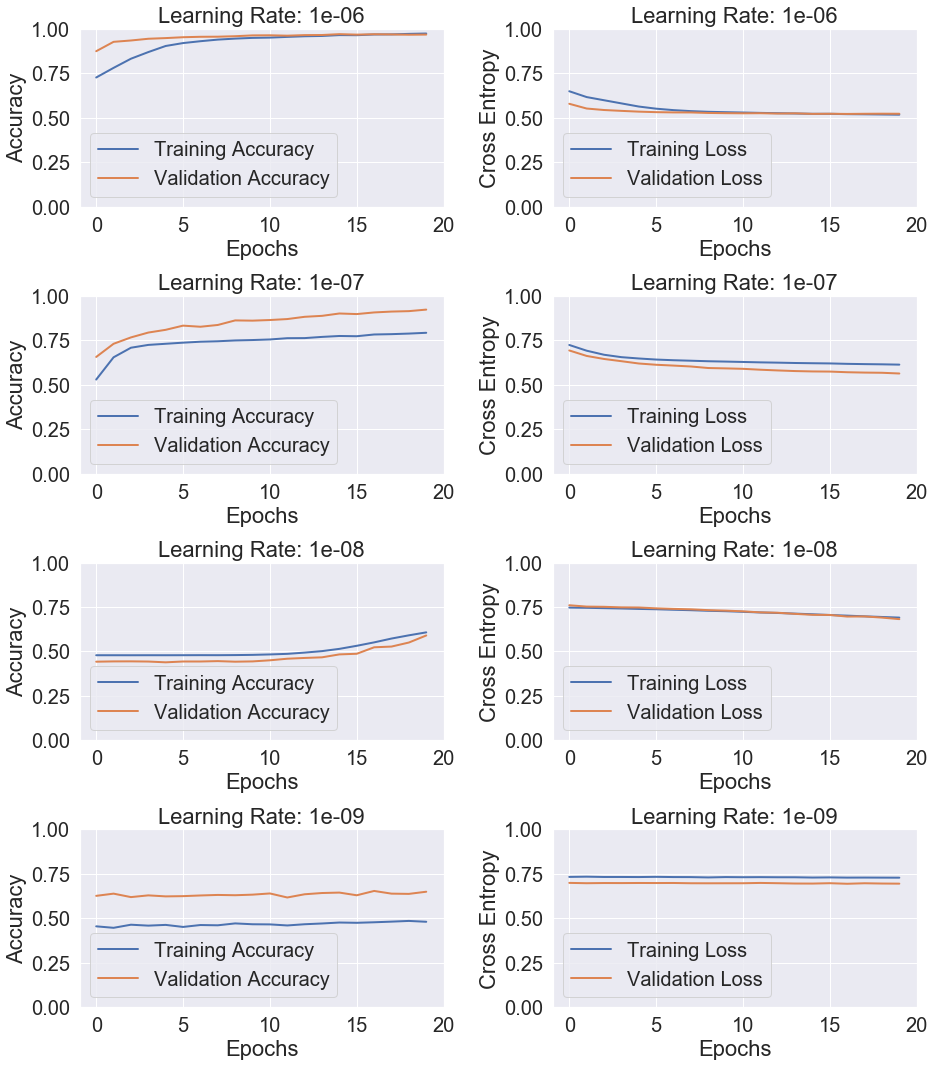

In [5]:
j = 1

plt.figure(figsize=(15,18))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
# plt.rcParams.update({'font.size': 30})
for (i, row) in data.iterrows():    
    history = pickle.load( open( row["history_path"], "rb" ))
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.subplot(4, 2, j)
    plt.plot(acc, label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Accuracy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')

    plt.subplot(4, 2, j+1)
    plt.plot(loss, label='Training Loss', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Cross Entropy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')
    
    j = j+2
#     break
    
plt.show()

# plt.savefig("images/mobilenet_acc_val_comparisons.png", format="png", pad_inches=-0.1)

In [6]:
eval_generator = datagen.flow_from_directory(
    directory = 'dataset/Bioconsult/32_32/Eval',
    batch_size = 2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle = False
)

con_mat = []
norm_con_mat = []
precision = 0
recall = 0
f1_score = 0

j = 1
for (i, row) in data.iterrows():
    base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Activation('relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=row["learning_rate"]),
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    y_real = eval_generator.classes
    
    y_pred = model.predict(eval_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_real, y_pred)
    norm_cm = np.around(cm/len(y_real), 3)
    
    print("\n")
    print("Learning rate:", row["learning_rate"])
    print(classification_report(y_real, y_pred, target_names = class_names))
    
    con_mat.append(cm)
    norm_con_mat.append(norm_cm)

Found 4729 images belonging to 2 classes.


Learning rate: 1e-06
              precision    recall  f1-score   support

   Not Whale       0.91      0.95      0.93      2041
       Whale       0.96      0.93      0.94      2688

    accuracy                           0.94      4729
   macro avg       0.93      0.94      0.94      4729
weighted avg       0.94      0.94      0.94      4729



Learning rate: 1e-07
              precision    recall  f1-score   support

   Not Whale       0.77      0.92      0.84      2041
       Whale       0.93      0.79      0.85      2688

    accuracy                           0.85      4729
   macro avg       0.85      0.86      0.85      4729
weighted avg       0.86      0.85      0.85      4729



Learning rate: 1e-08
              precision    recall  f1-score   support

   Not Whale       0.77      0.32      0.45      2041
       Whale       0.64      0.93      0.76      2688

    accuracy                           0.66      4729
   macro avg     

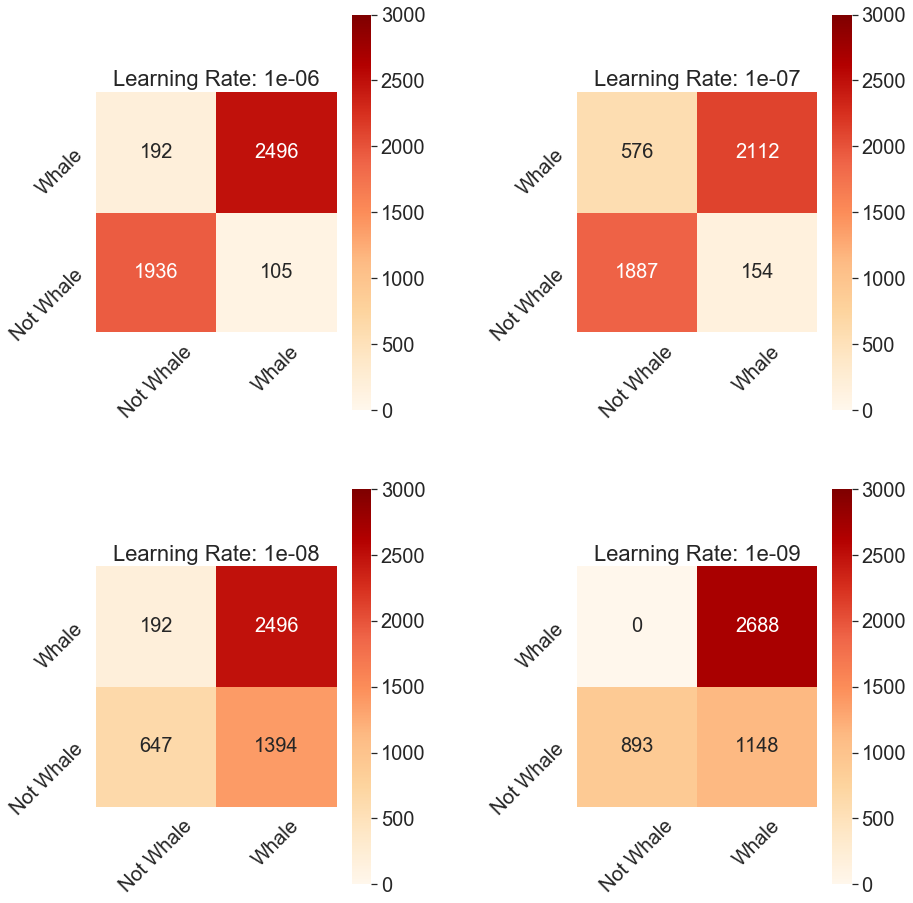

In [7]:
plt.figure(figsize = (14,16))
plt.subplots_adjust(wspace = 0.6, hspace = 0.2)

j = 1
for i, matrices in enumerate(zip(con_mat, norm_con_mat)):
    row = data.iloc[i]
    
    plt.subplot(int(len(data)/2), 2, j)
    df_cm = pd.DataFrame(matrices[0], index = ["Not Whale", "Whale"], columns = ["Not Whale", "Whale"])
    sns.heatmap(df_cm, annot=True, cmap="OrRd", fmt='g', vmin=0, vmax=3000, square = True, cbar=True)
    plt.ylim([0, 2])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)    
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    j = j+1
    
# plt.show()

plt.savefig("images/mobilenet_conf_mat_comparisons.png", format="png")

In [8]:
sizes = [0, 1, 2, 3, 4, 5]
model_acc = []

for (i, row) in data.iterrows():
    base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Activation('relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=row["learning_rate"]),
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    print("Model Loaded")
    
    accuracies = []
    
    
    for s in sizes:
        clear_output()
        print(i,s)
        
        eval_generator = datagen.flow_from_directory(
            directory = 'dataset/Bioconsult/downsampled/'+str(s)+'/Eval',
            batch_size = 2,
            target_size=(224, 224),
            class_mode='categorical',
            shuffle = False
        )

        y_real = eval_generator.classes
    
        y_pred = model.predict(eval_generator)
        y_pred = np.argmax(y_pred, axis=1)
        
        accuracies.append({
            "learning_rate": row["learning_rate"],
            "accuracy": accuracy_score(y_real, y_pred, normalize=True),
            "precision": precision_score(y_real, y_pred, average='micro'),
            "recall": recall_score(y_real, y_pred, average='micro')
        })
        
    model_acc.append(accuracies)

3 5
Found 4729 images belonging to 2 classes.


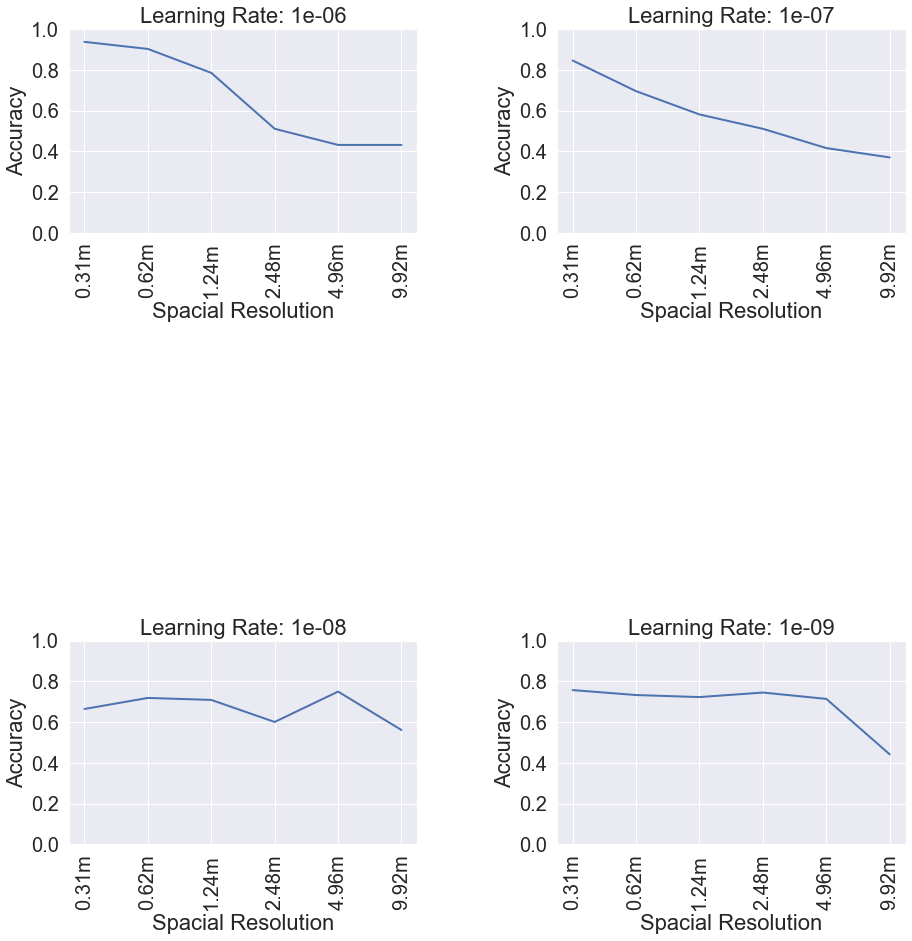

In [9]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace = 0.4, hspace = 2)

samp_sizes = ["0.31m", "0.62m", "1.24m", "2.48m", "4.96m", "9.92m"]

i = 1
for acc in model_acc:
    plt.subplot(2, 2, i)
    plt.plot(samp_sizes, [a["accuracy"] for a in acc], label='Accuracy', linewidth = 2)
    plt.ylim([0, 1.0])
    plt.ylabel('Accuracy')
    plt.xlabel('Spacial Resolution')
    plt.xticks(rotation=90)
    plt.title('Learning Rate: '+str(acc[0]["learning_rate"]))
    
    i += 1

plt.savefig("images/mobilenet_samp_size_comparisons.png", format="png")

## Producing the results for XceptionV1

In [10]:
data = pd.read_csv("xception_results.csv")
data

,learning_rate,model_path,history_path,time_taken,time_taken_hrs
0,1.000000e-06,trained_models/xception_1e-06.h5,trained_models/xception_history_1e-06.p,20565.533767,05:42:45.534
1,1.000000e-08,trained_models/xception_1e-08.h5,trained_models/xception_history_1e-08.p,20447.661613,05:40:47.662


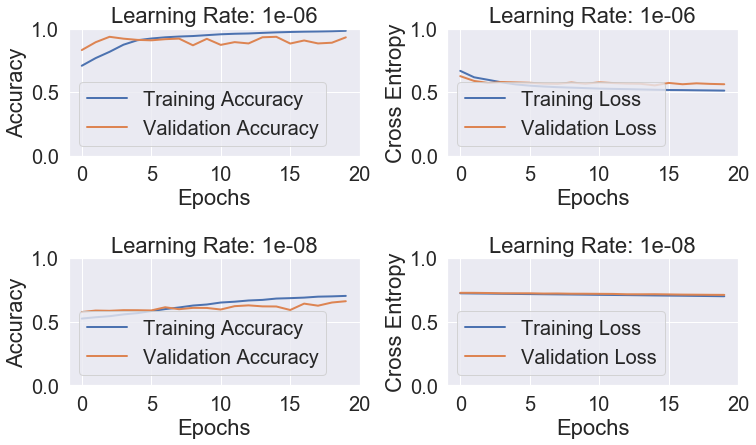

In [11]:
j = 1

plt.figure(figsize=(12,15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.8)
# plt.rcParams.update({'font.size': 30})
for (i, row) in data.iterrows():    
    history = pickle.load( open( row["history_path"], "rb" ))
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.subplot(4, 2, j)
    plt.plot(acc, label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Accuracy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')

    plt.subplot(4, 2, j+1)
    plt.plot(loss, label='Training Loss', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Cross Entropy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')
    
    j = j+2
#     break
    
# plt.show()

plt.savefig("images/xception_acc_val_comparisons.png", format="png")

In [12]:
eval_generator = datagen.flow_from_directory(
    directory = 'dataset/Bioconsult/32_32/Eval',
    batch_size = 2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle = False
)

con_mat = []
norm_con_mat = []
precision = 0
recall = 0
f1_score = 0

j = 1
for (i, row) in data.iterrows():
    base_model = tf.keras.applications.Xception(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Activation('relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=row["learning_rate"]),
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    y_real = eval_generator.classes
    
    y_pred = model.predict(eval_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_real, y_pred)
    norm_cm = np.around(cm/len(y_real), 3)
    
    print("\n")
    print("Learning rate:",row["learning_rate"])
    print(classification_report(y_real, y_pred, target_names = class_names))
    
    con_mat.append(cm)
    norm_con_mat.append(norm_cm)

Found 4729 images belonging to 2 classes.


Learning rate: 1e-06
              precision    recall  f1-score   support

   Not Whale       1.00      0.90      0.95      2041
       Whale       0.93      1.00      0.96      2688

    accuracy                           0.96      4729
   macro avg       0.97      0.95      0.96      4729
weighted avg       0.96      0.96      0.96      4729



Learning rate: 1e-08
              precision    recall  f1-score   support

   Not Whale       0.49      0.99      0.65      2041
       Whale       0.96      0.21      0.35      2688

    accuracy                           0.55      4729
   macro avg       0.73      0.60      0.50      4729
weighted avg       0.76      0.55      0.48      4729



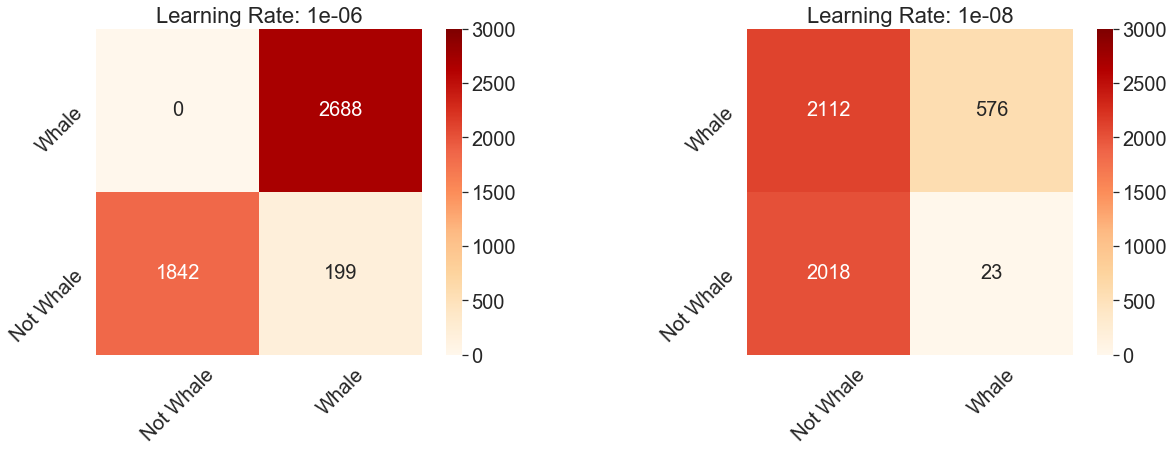

In [13]:
plt.figure(figsize = (20,6))
plt.subplots_adjust(wspace = 0.4, hspace = 0.8)

j = 1
for i, matrices in enumerate(zip(con_mat, norm_con_mat)):
    row = data.iloc[i]
    
    plt.subplot(int(len(data)/2), 2, j)
    df_cm = pd.DataFrame(matrices[0], index = ["Not Whale", "Whale"], columns = ["Not Whale", "Whale"])
    sns.heatmap(df_cm, annot=True, cmap="OrRd", fmt='g', vmin=0, vmax=3000, square = True, cbar=True)
    plt.ylim([0, 2])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)    
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    j = j+1
    
# plt.show()
plt.savefig("images/xception_conf_mat_comparisons.png", format="png")

In [14]:
sizes = [0, 1, 2, 3, 4, 5]
model_acc = []

for (i, row) in data.iterrows():
    base_model = tf.keras.applications.Xception(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    global_average_layer = layers.GlobalAveragePooling2D()

    classes_layer = layers.Dense(2, activation = 'sigmoid')

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        classes_layer,
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr = row["learning_rate"]), #0.00000001
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    print("Model Loaded")
    
    accuracies = []
    
    
    for s in sizes:
        clear_output()
        print(i,s)
        
        eval_generator = datagen.flow_from_directory(
            directory = 'dataset/Bioconsult/downsampled/'+str(s)+'/Eval',
            batch_size = 2,
            target_size=(224, 224),
            class_mode='categorical',
            shuffle = False
        )

        y_real = eval_generator.classes
    
        y_pred = model.predict(eval_generator)
        y_pred = np.argmax(y_pred, axis=1)
        
        accuracies.append({
            "learning_rate": row["learning_rate"],
            "accuracy": accuracy_score(y_real, y_pred, normalize=True),
            "precision": precision_score(y_real, y_pred, average='micro'),
            "recall": recall_score(y_real, y_pred, average='micro')
        })
        
    model_acc.append(accuracies)

1 5
Found 4729 images belonging to 2 classes.


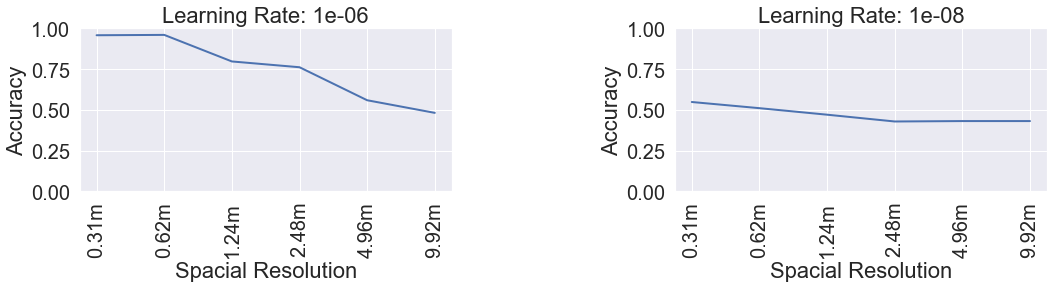

In [15]:
plt.figure(figsize=(60,3))
plt.subplots_adjust(wspace = 0.6)

samp_sizes = ["0.31m", "0.62m", "1.24m", "2.48m", "4.96m", "9.92m"]

i = 1
for acc in model_acc:
    plt.subplot(1, len(sizes), i)
    plt.plot(samp_sizes, [a["accuracy"] for a in acc], label='Accuracy', linewidth = 2)
    plt.ylim([0, 1.0])
    plt.ylabel('Accuracy')
    plt.xlabel('Spacial Resolution')
    plt.xticks(rotation=90)
    plt.title('Learning Rate: '+str(acc[0]["learning_rate"]))
    
    i += 1
    
plt.show()

## Producing the results for Resnet152-V2

In [16]:
data = pd.read_csv("resnet_results.csv")
data

,learning_rate,model_path,history_path,time_taken,time_taken_hrs
0,1.000000e-06,trained_models/resnet152_V2_1e-06.h5,trained_models/resnet152_V2_history_1e-06.p,40034.251675,11:07:14.252
1,1.000000e-07,trained_models/resnet152_V2_1e-07.h5,trained_models/resnet152_V2_history_1e-07.p,40118.439719,11:08:38.440
2,1.000000e-08,trained_models/resnet152_V2_1e-08.h5,trained_models/resnet152_V2_history_1e-08.p,40078.161512,11:07:58.162


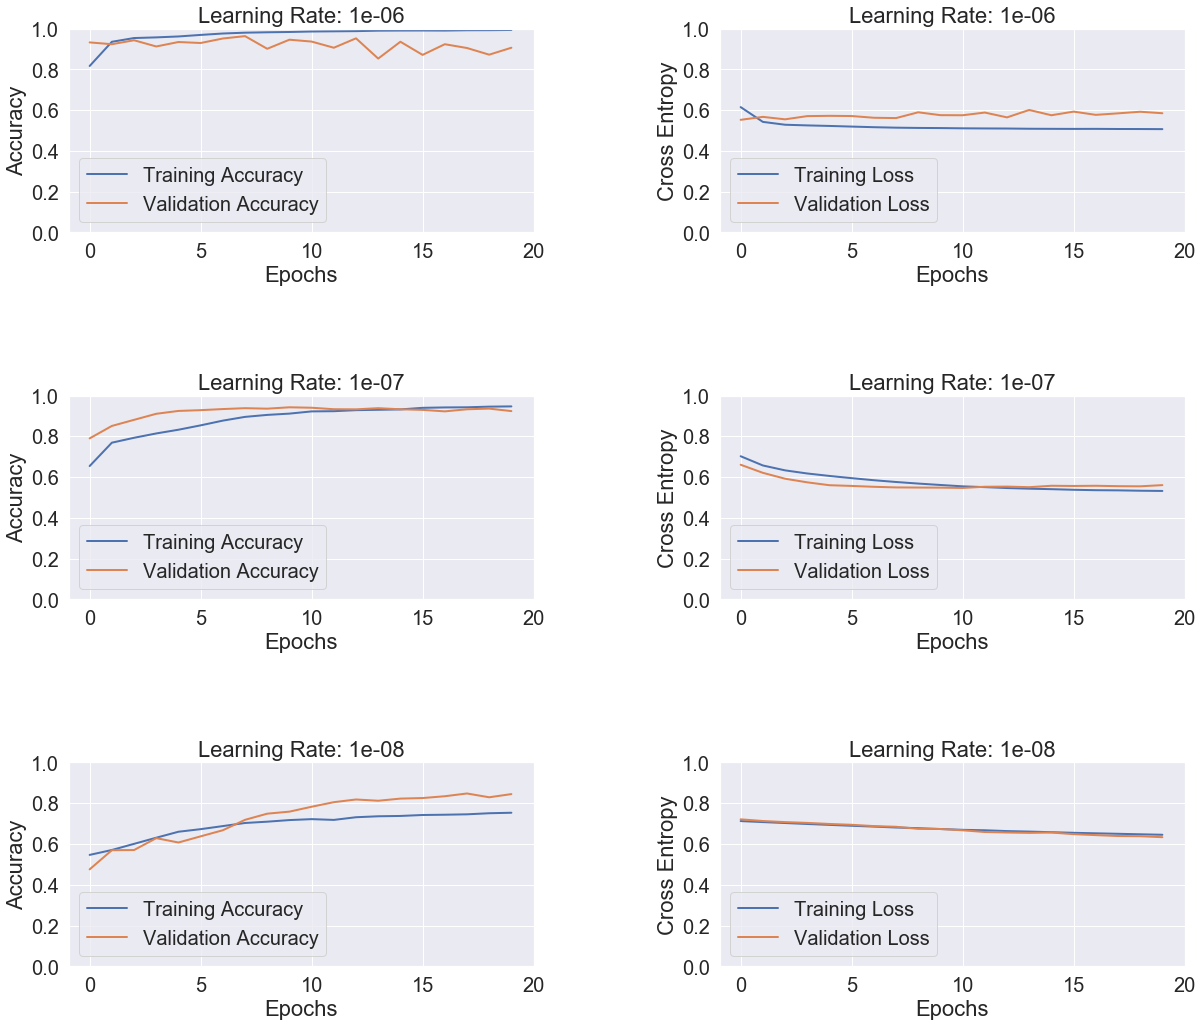

In [17]:
j = 1

plt.figure(figsize=(20,24))
plt.subplots_adjust(wspace = 0.4, hspace = 0.8)
# plt.rcParams.update({'font.size': 30})
for (i, row) in data.iterrows():    
    history = pickle.load( open( row["history_path"], "rb" ))
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.subplot(4, 2, j)
    plt.plot(acc, label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Accuracy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')

    plt.subplot(4, 2, j+1)
    plt.plot(loss, label='Training Loss', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Cross Entropy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')
    
    j = j+2
#     break
    
# plt.show()

plt.savefig("images/resnet_acc_val_comparisons.png", format="png")

In [18]:
eval_generator = datagen.flow_from_directory(
    directory = 'dataset/Bioconsult/32_32/Eval',
    batch_size = 2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle = False
)

con_mat = []
norm_con_mat = []
precision = 0
recall = 0
f1_score = 0

j = 1
for (i, row) in data.iterrows():
    base_model = tf.keras.applications.ResNet152V2(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Activation('relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=row["learning_rate"]),
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    y_real = eval_generator.classes
    
    y_pred = model.predict(eval_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_real, y_pred)
    norm_cm = np.around(cm/len(y_real), 3)
    
    print("\n")
    print("Learning rate:",row["learning_rate"])
    print(classification_report(y_real, y_pred, target_names = class_names))
    
    con_mat.append(cm)
    norm_con_mat.append(norm_cm)

Found 4729 images belonging to 2 classes.


Learning rate: 1e-06
              precision    recall  f1-score   support

   Not Whale       1.00      0.77      0.87      2041
       Whale       0.85      1.00      0.92      2688

    accuracy                           0.90      4729
   macro avg       0.93      0.89      0.90      4729
weighted avg       0.92      0.90      0.90      4729



Learning rate: 1e-07
              precision    recall  f1-score   support

   Not Whale       1.00      0.92      0.96      2041
       Whale       0.95      1.00      0.97      2688

    accuracy                           0.97      4729
   macro avg       0.97      0.96      0.97      4729
weighted avg       0.97      0.97      0.97      4729



Learning rate: 1e-08
              precision    recall  f1-score   support

   Not Whale       0.71      0.90      0.79      2041
       Whale       0.91      0.71      0.80      2688

    accuracy                           0.80      4729
   macro avg     

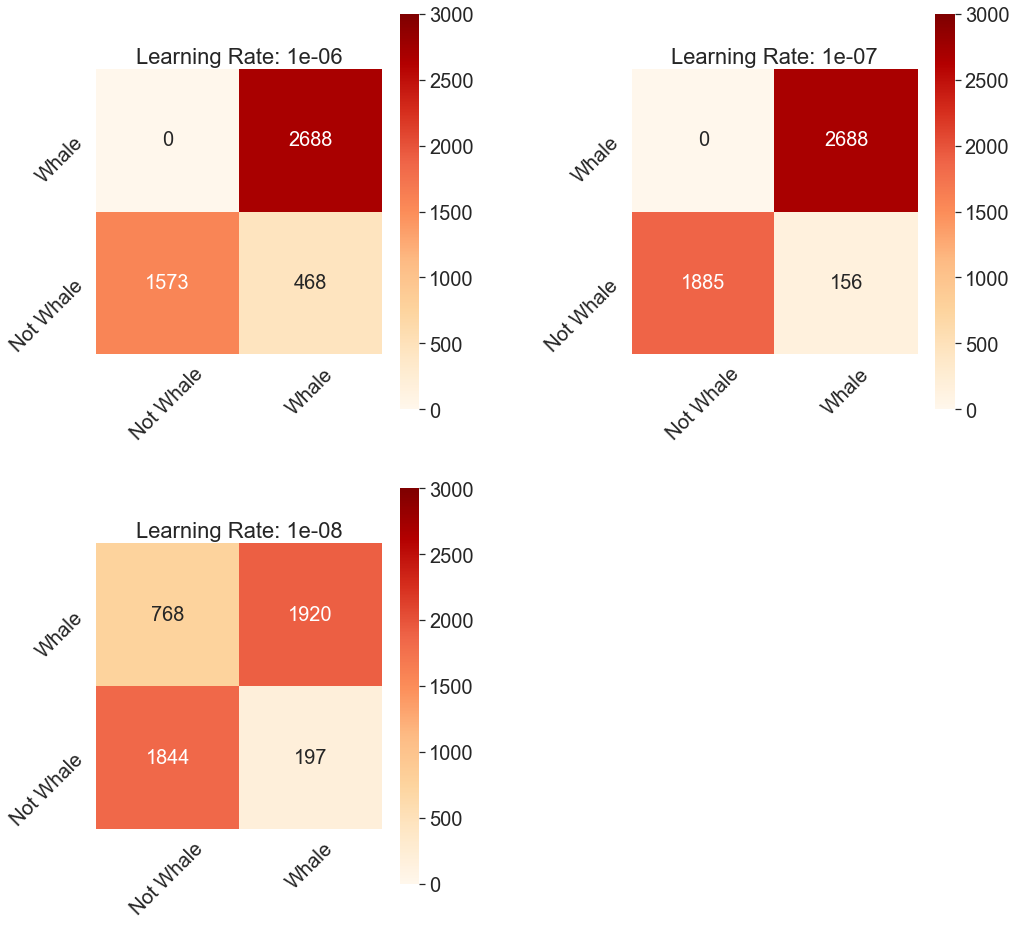

In [19]:
plt.figure(figsize = (16,16))
plt.subplots_adjust(wspace = 0.5, hspace = 0.2)

j = 1
for i, matrices in enumerate(zip(con_mat, norm_con_mat)):
    row = data.iloc[i]
    
    plt.subplot(2, 2, j)
    df_cm = pd.DataFrame(matrices[0], index = ["Not Whale", "Whale"], columns = ["Not Whale", "Whale"])
    sns.heatmap(df_cm, annot=True, cmap="OrRd", fmt='g', vmin=0, vmax=3000, square = True, cbar=True)
    plt.ylim([0, 2])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)    
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    j = j+1
    
#     plt.subplot(int(len(data)/2), 2, j+1)
#     df_cm = pd.DataFrame(matrices[1], index = class_names, columns = class_names)
#     sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', vmin=0, vmax=1, square = True, cbar=True)
#     plt.ylim([0, 2])
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=45)
#     plt.title('Learning Rate: '+str(row["learning_rate"]))
#     j = j+2
    
# plt.show()

plt.savefig("images/resnet_conf_mat_comparisons.png", format="png")

In [20]:
sizes = [0, 1, 2, 3, 4, 5]
model_acc = []

for (i, row) in data.iterrows():
    base_model = tf.keras.applications.ResNet152V2(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Activation('relu'),
        layers.Dense(2, activation = 'softmax'),
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=row["learning_rate"]),
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    print("Model Loaded")
    
    accuracies = []
    
    
    for s in sizes:
        clear_output()
        print(i,s)
        
        eval_generator = datagen.flow_from_directory(
            directory = 'dataset/Bioconsult/downsampled/'+str(s)+'/Eval',
            batch_size = 2,
            target_size=(224, 224),
            class_mode='categorical',
            shuffle = False
        )

        y_real = eval_generator.classes
    
        y_pred = model.predict(eval_generator)
        y_pred = np.argmax(y_pred, axis=1)
        
        accuracies.append({
            "learning_rate": row["learning_rate"],
            "accuracy": accuracy_score(y_real, y_pred, normalize=True),
            "precision": precision_score(y_real, y_pred, average='micro'),
            "recall": recall_score(y_real, y_pred, average='micro')
        })
        
    model_acc.append(accuracies)

2 5
Found 4729 images belonging to 2 classes.


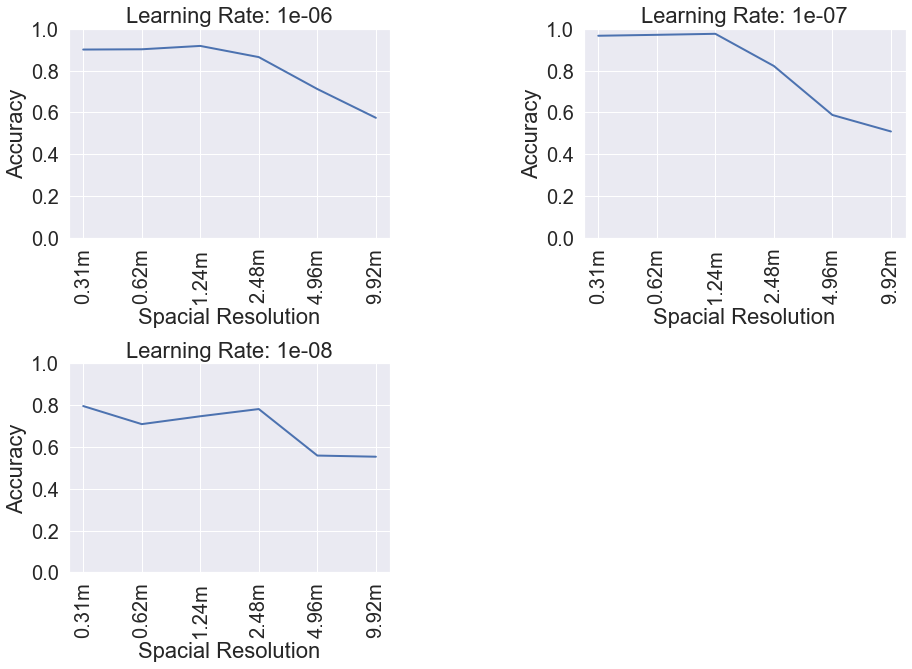

In [21]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace = 0.6, hspace = 0.6)

samp_sizes = ["0.31m", "0.62m", "1.24m", "2.48m", "4.96m", "9.92m"]

i = 1
for acc in model_acc:
    plt.subplot(2, 2, i)
    plt.plot(samp_sizes, [a["accuracy"] for a in acc], label='Accuracy', linewidth = 2)
    plt.ylim([0, 1.0])
    plt.ylabel('Accuracy')
    plt.xlabel('Spacial Resolution')
    plt.xticks(rotation=90)
    plt.title('Learning Rate: '+str(acc[0]["learning_rate"]))
    i += 1
    
    
plt.show()

## Producing the results for Densenet201

In [22]:
data = pd.read_csv("densenet_results.csv")
data

,learning_rate,model_path,history_path,time_taken,time_taken_hrs
0,1.000000e-07,trained_models/densenet201_1e-07.h5,trained_models/densenet201_history_1e-07.p,27465.695158,07:37:45.695
1,1.000000e-08,trained_models/densenet201_1e-08.h5,trained_models/densenet201_history_1e-08.p,27434.004640,07:37:14.005


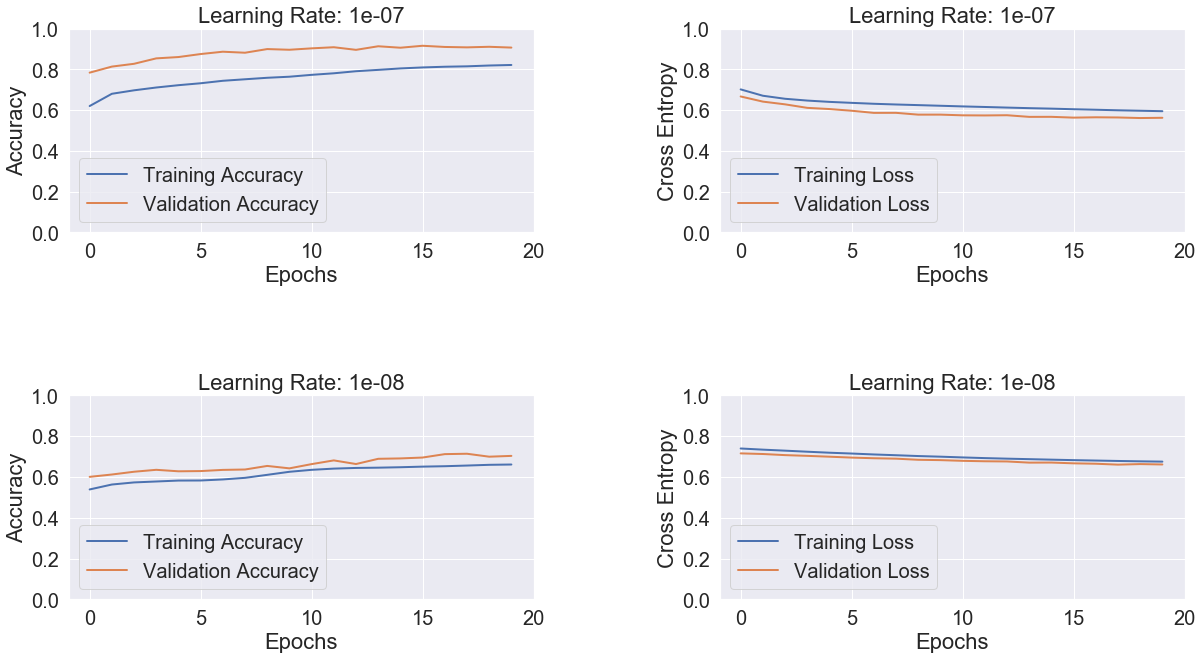

In [23]:
j = 1

plt.figure(figsize=(20,24))
plt.subplots_adjust(wspace = 0.4, hspace = 0.8)
# plt.rcParams.update({'font.size': 30})
for (i, row) in data.iterrows():    
    history = pickle.load( open( row["history_path"], "rb" ))
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.subplot(4, 2, j)
    plt.plot(acc, label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Accuracy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')

    plt.subplot(4, 2, j+1)
    plt.plot(loss, label='Training Loss', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', linewidth=2)
    plt.legend(loc='lower left')
    plt.ylabel('Cross Entropy')
    plt.xticks(range(0,21,5))
    plt.ylim([0, 1.0])
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    plt.xlabel('Epochs')
    
    j = j+2
#     break
    
# plt.show()

plt.savefig("densenet_acc_val_comparisons.svg", format="svg")

In [24]:
eval_generator = datagen.flow_from_directory(
    directory = 'dataset/Bioconsult/32_32/Eval',
    batch_size = 2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle = False
)

con_mat = []
norm_con_mat = []
precision = 0
recall = 0
f1_score = 0

j = 1
for (i, row) in data.iterrows():
    base_model = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    global_average_layer = layers.GlobalAveragePooling2D()

    classes_layer = layers.Dense(2, activation = 'sigmoid')

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        classes_layer,
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr = row["learning_rate"]), #0.00000001
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    y_real = eval_generator.classes
    
    y_pred = model.predict(eval_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_real, y_pred)
    norm_cm = np.around(cm/len(y_real), 3)
    
    print("\n")
    print("Learning rate:",row["learning_rate"])
    print(classification_report(y_real, y_pred, target_names = class_names))
    
    con_mat.append(cm)
    norm_con_mat.append(norm_cm)

Found 4729 images belonging to 2 classes.


Learning rate: 1e-07
              precision    recall  f1-score   support

   Not Whale       0.91      0.94      0.92      2041
       Whale       0.95      0.93      0.94      2688

    accuracy                           0.93      4729
   macro avg       0.93      0.93      0.93      4729
weighted avg       0.93      0.93      0.93      4729



Learning rate: 1e-08
              precision    recall  f1-score   support

   Not Whale       0.51      0.88      0.64      2041
       Whale       0.79      0.36      0.49      2688

    accuracy                           0.58      4729
   macro avg       0.65      0.62      0.57      4729
weighted avg       0.67      0.58      0.56      4729



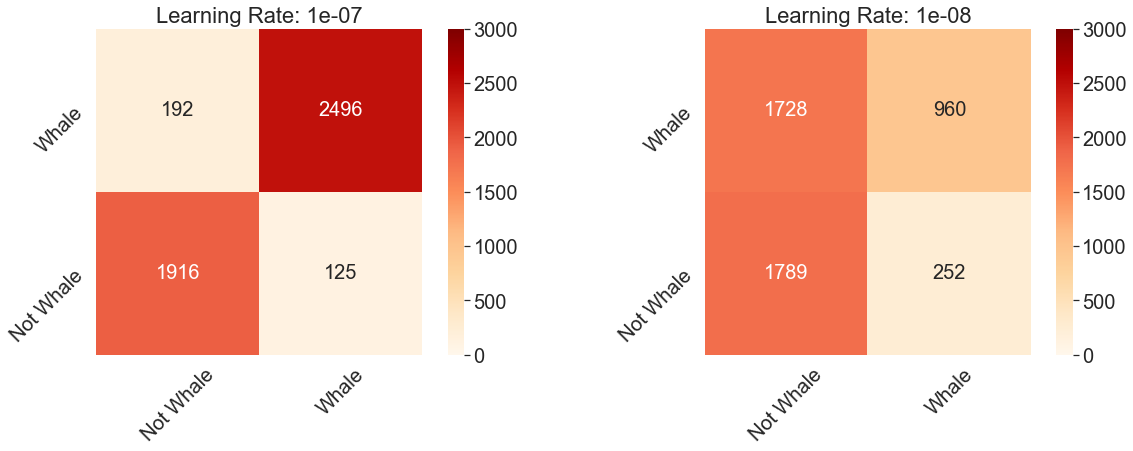

In [25]:
plt.figure(figsize = (20,6))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

j = 1
for i, matrices in enumerate(zip(con_mat, norm_con_mat)):
    row = data.iloc[i]
    
    plt.subplot(int(len(data)/2), 2, j)
    df_cm = pd.DataFrame(matrices[0], index = ["Not Whale", "Whale"], columns = ["Not Whale", "Whale"])
    sns.heatmap(df_cm, annot=True, cmap="OrRd", fmt='g', vmin=0, vmax=3000, square = True, cbar=True)
    plt.ylim([0, 2])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)    
    plt.title('Learning Rate: '+str(row["learning_rate"]))
    j = j+1
    
#     plt.subplot(int(len(data)/2), 2, j+1)
#     df_cm = pd.DataFrame(matrices[1], index = class_names, columns = class_names)
#     sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', vmin=0, vmax=1, square = True, cbar=True)
#     plt.ylim([0, 2])
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=45)
#     plt.title('Learning Rate: '+str(row["learning_rate"]))
#     j = j+2
    
# plt.show()

plt.savefig("images/densenet_conf_mat_comparisons.png", format="png")

In [26]:
sizes = [0, 1, 2, 3, 4, 5]
model_acc = []

for (i, row) in data.iterrows():
    base_model = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    global_average_layer = layers.GlobalAveragePooling2D()

    classes_layer = layers.Dense(2, activation = 'sigmoid')

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        classes_layer,
    ])

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr = row["learning_rate"]),
                  metrics=['accuracy'])


    model.load_weights(row["model_path"])
    
    print("Model Loaded")
    
    accuracies = []
    
    
    for s in sizes:
        clear_output()
        print(i,s)
        
        eval_generator = datagen.flow_from_directory(
            directory = 'dataset/Bioconsult/downsampled/'+str(s)+'/Eval',
            batch_size = 2,
            target_size=(224, 224),
            class_mode='categorical',
            shuffle = False
        )

        y_real = eval_generator.classes
    
        y_pred = model.predict(eval_generator)
        y_pred = np.argmax(y_pred, axis=1)
        
        accuracies.append({
            "learning_rate": row["learning_rate"],
            "accuracy": accuracy_score(y_real, y_pred, normalize=True),
            "precision": precision_score(y_real, y_pred, average='micro'),
            "recall": recall_score(y_real, y_pred, average='micro')
        })
        
    model_acc.append(accuracies)

1 5
Found 4729 images belonging to 2 classes.


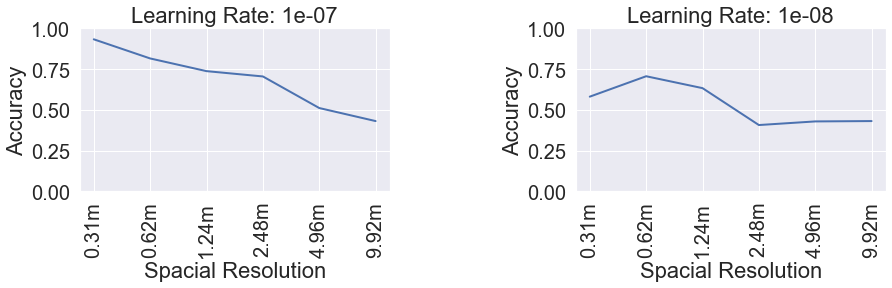

In [27]:
plt.figure(figsize=(50,3))
plt.subplots_adjust(wspace = 0.6)

samp_sizes = ["0.31m", "0.62m", "1.24m", "2.48m", "4.96m", "9.92m"]

i = 1
for acc in model_acc:
    plt.subplot(1, len(sizes), i)
    plt.plot(samp_sizes, [a["accuracy"] for a in acc], label='Accuracy', linewidth = 2)
    plt.ylim([0, 1.0])
    plt.ylabel('Accuracy')
    plt.xlabel('Spacial Resolution')
    plt.xticks(rotation=90)
    plt.title('Learning Rate: '+str(acc[0]["learning_rate"]))
    
    i += 1
plt.show()